# Part A: Grab the Data

We'll start by loading the data into a dataframe:

In [186]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
train = pd.read_csv(url)

We'll take a peak at how the data looks:

In [187]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


# Part B: Explore The Data

Create at least two visualizations and one summary table in which you explore patterns in the data. You might consider some questions like:

How does loan intent vary with the age, length of employment, or homeownership status of an individual?

Which segments of prospective borrowers are offered low interest rates? Which segments are offered high interest rates?

Which segments of prospective borrowers have access to large lines of credit?

#### Summary table
The following table shows the means of each quantitative column, grouped by loan_grade, descending from the best grade 'A', denoting confidence that the recipient will pay back the loan, to the worst grade 'G', denoting the least confidence that the recipient will pay back the loan. We can see that loan as percent of income increases as the loan grade decreases. 
Loan amount increases as the loan grade decreases.
Loan interest rate increases as the loan grade decreases.

Interesting: the lower grades have a higher income.

I've selected just the columns with quantitative information and cleaned the data by removing rows with missing values.

In [188]:
quant_col = ["loan_grade", "loan_percent_income", "person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "cb_person_cred_hist_length"]
train_quant = train[quant_col].dropna()
train_quant.groupby(["loan_grade"]).aggregate("mean") #, "person_home_ownership"

,loan_percent_income,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length
loan_grade,,,,,,,
A,0.152629,27.682077,66773.007816,5.122533,8555.884885,7.338368,5.730560
B,0.173846,27.673949,66662.091096,4.750069,10031.025007,11.003273,5.766007
C,0.168928,27.792667,66416.633130,4.402663,9322.102794,13.456237,5.855303
D,0.188833,27.853112,64555.473908,4.699652,10821.646695,15.358261,5.861229
E,0.204190,27.732955,70868.349432,4.458807,12929.083807,17.047344,5.747159
F,0.220982,28.564417,80756.546012,4.239264,15395.705521,18.519018,6.214724
G,0.243409,28.181818,77342.477273,5.954545,17384.659091,20.230000,6.500000


Let's load our visualization library:

In [189]:
import seaborn as sns

#### Visualization 1



<Axes: xlabel='cb_person_default_on_file', ylabel='loan_amnt'>

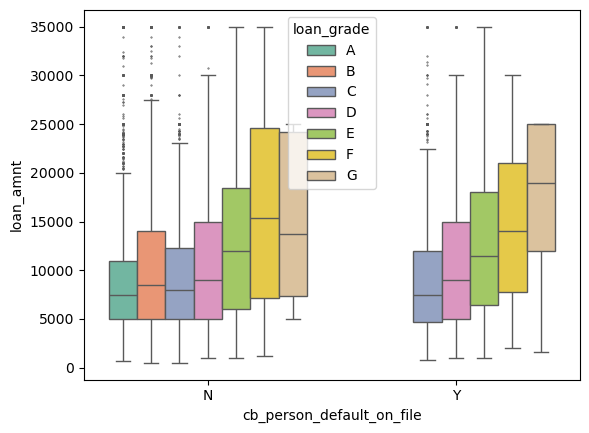

In [190]:
sns.boxplot(train, x="cb_person_default_on_file", y="loan_amnt", hue_order=["A", "B", "C", "D", "E", "F", "G"], hue="loan_grade", palette="Set2", fliersize=0.5)

#### Visualization 2

Here we visualize a scatterplot where loan percent income is on the x-axis, and loan interest rate is on the y-axis. The color of the data corresponds to the loan grade given by the bank.

We can see that loan interest rate has a high correlation to loan grade - the higher the interest rate, the lower the loan grade.

<Axes: xlabel='loan_percent_income', ylabel='loan_int_rate'>

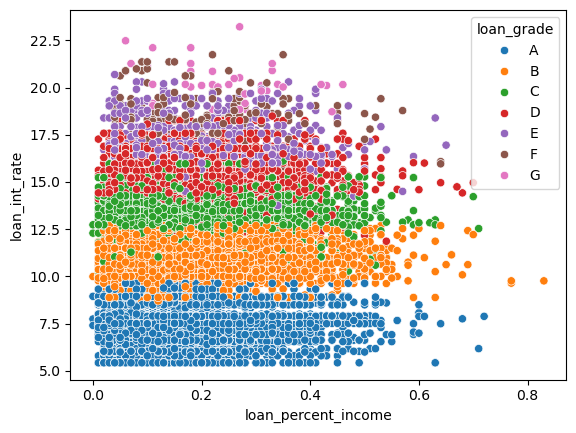

In [191]:
order_loan_grade = ["A", "B", "C", "D", "E", "F", "G"]
sns.scatterplot(train, x="loan_percent_income", y="loan_int_rate", hue="loan_grade", hue_order=order_loan_grade)

# Part C: Build a Model

We're going to use cross validation to score all combinations of features to find the best ones to use in our model.

### Data Preparation

In order to find the optimal variables for a model, we need to prep the data - specifically dropping rows with NAs and using one-hot encoding to turn the categorical variables into numerical ones.

In [192]:
train = train.dropna()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["loan_status"])

def prepare_data(df):
  y = le.transform(df["loan_status"])
  df = df.drop(["loan_status"], axis = 1)
  df = 1*pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

If we check how our data looks, we can see each categorical variable now is represented by multiple columns with binary values.

In [193]:
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,27,98000,3.0,11750,13.47,0.12,6,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,22,36996,5.0,10000,7.51,0.27,4,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,24,26000,2.0,1325,12.87,0.05,4,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,29,53004,2.0,15000,9.63,0.28,10,1,0,0,...,0,1,0,0,0,0,0,0,1,0
6,21,21700,2.0,5500,14.91,0.25,2,0,0,0,...,0,0,0,0,1,0,0,0,1,0


We will use the ``combinations`` function from the ``itertools`` package. This will list all the combinations of one discreet variable and two continuous variables. Iterating through all the possible combinations, it will A) score the model using cross validation, and B) return the best combination of columns that performed the best.

In [200]:
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from sklearn.model_selection import cross_val_score

LR = LogisticRegression(max_iter=999)

all_qual_cols = ["person_home_ownership", "loan_intent", "cb_person_default_on_file"]
all_quant_cols = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]

score = 0
cols_best = []

for qual in all_qual_cols:
    qual_cols = [col for col in X_train.columns if qual in col]
    for pair in combinations(all_quant_cols, 2):
        cols = qual_cols + list(pair)

        #fit the models
        log_score = cross_val_score(LR, X_train[cols], y_train, cv = 5).mean()

        #compare the scores
        if log_score > score:
            score = log_score
            cols_best = cols

#output the best score, along with the corresponding columns
print(score)
print(cols_best)


0.8488229950993185
['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'person_age', 'loan_percent_income']


Looks like the best features to use are: loan_intent, person_age, and loan_percent_income

In [195]:
LR = LogisticRegression(max_iter=999999999)
model = LR.fit(X_train, y_train)

/Users/charliemoore/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [197]:
# our weights are now stored in:
model.coef_

array([[-1.16206181e-02, -2.19013768e-06, -1.15976369e-02,
        -7.43855119e-05,  8.46994452e-02,  1.10447932e+01,
         6.25277875e-03, -2.41035039e-01,  3.00525449e-01,
        -1.79659272e+00,  6.11002763e-01,  2.47124918e-01,
        -5.71537581e-01,  2.19625107e-01,  7.87737793e-02,
        -3.59884526e-01, -7.40200649e-01, -1.95952390e+00,
        -1.88778968e+00, -1.69225163e+00,  2.87132824e-01,
         2.83933615e-01,  1.85662948e+00,  1.98577027e+00,
        -5.77138851e-01, -5.48959998e-01]])

# Part D: Find a Threshold

Once you have a weight vector **w**, it is time to choose a threshold *t*. To choose a threshold that maximizes profit for the bank, we need to make some assumptions about how the bank makes and loses money on loans. Let’s use the following (simplified) modeling assumptions:

If the loan is repaid in full, the profit for the bank is equal to ``loan_amnt*(1 + 0.25*loan_int_rate)**10 - loan_amnt``. This formula assumes that the profit earned by the bank on a 10-year loan is equal to 25% of the interest rate each year, with the other 75% of the interest going to things like salaries for the people who manage the bank. It is extremely simplistic and does not account for inflation, amortization over time, opportunity costs, etc.
If the borrower defaults on the loan, the “profit” for the bank is equal to ``loan_amnt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amnt``. This formula corresponds to the same profit-earning mechanism as above, but assumes that the borrower defaults three years into the loan and that the bank loses 70% of the principal.
These modeling assumptions are extremely simplistic! You may deviate from these assumptions if you have relevant prior knowledge to inform your approach!!

Based on your assumptions, determine the threshold *t* which optimizes profit for the bank on the training set. Explain your approach, including labeled visualizations where appropriate, and include a final estimate of the bank’s expected profit per borrower on the training set.

# Part E: Evaluate Your Model from the Bank’s Perspective

Only after you have finalized your weight **w** vector  and threshold *t*, evaluate your automated decision-process on the test set:

In [198]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
train_test = pd.read_csv(url)

What is the expected profit per borrower on the test set? Is it similar to your profit on the training set?

# Part F: Evaluate Your Model From the Borrower’s Perspective

Now evaluate your model from the (aggregate) perspective of the prospective borrowers. Please quantitatively address the following questions, using the predictions of your model on the test data:

1. Is it more difficult for people in certain age groups to access credit under your proposed system?
2. Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group? What about people seeking loans for business ventures or education?
3. How does a person’s income level impact the ease with which they can access credit under your decision system?

# Part G: Write and Reflect

Write a brief introductory paragraph for your blog post describing the overall purpose, methodology, and findings of your study. Then, write a concluding discussion describing what you found and what you learned through from this blog post.

Please include one paragraph discussing the following questions:

Considering that people seeking loans for medical expense have high rates of default, is it fair that it is more difficult for them to obtain access to credit?
You are free to define “fairness” in a way that makes sense to you, but **please write down your definition** as part of your discussion.